<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. У нас есть исторические данные о поведении клиентов и расторжении договоров с банком. 

Нужно построить модель с предельно большим значением *F1*-меры и довести метрику до 0.59. 

Дополнительно измерить *AUC-ROC*, сравнив её значение с *F1*-мерой.


## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


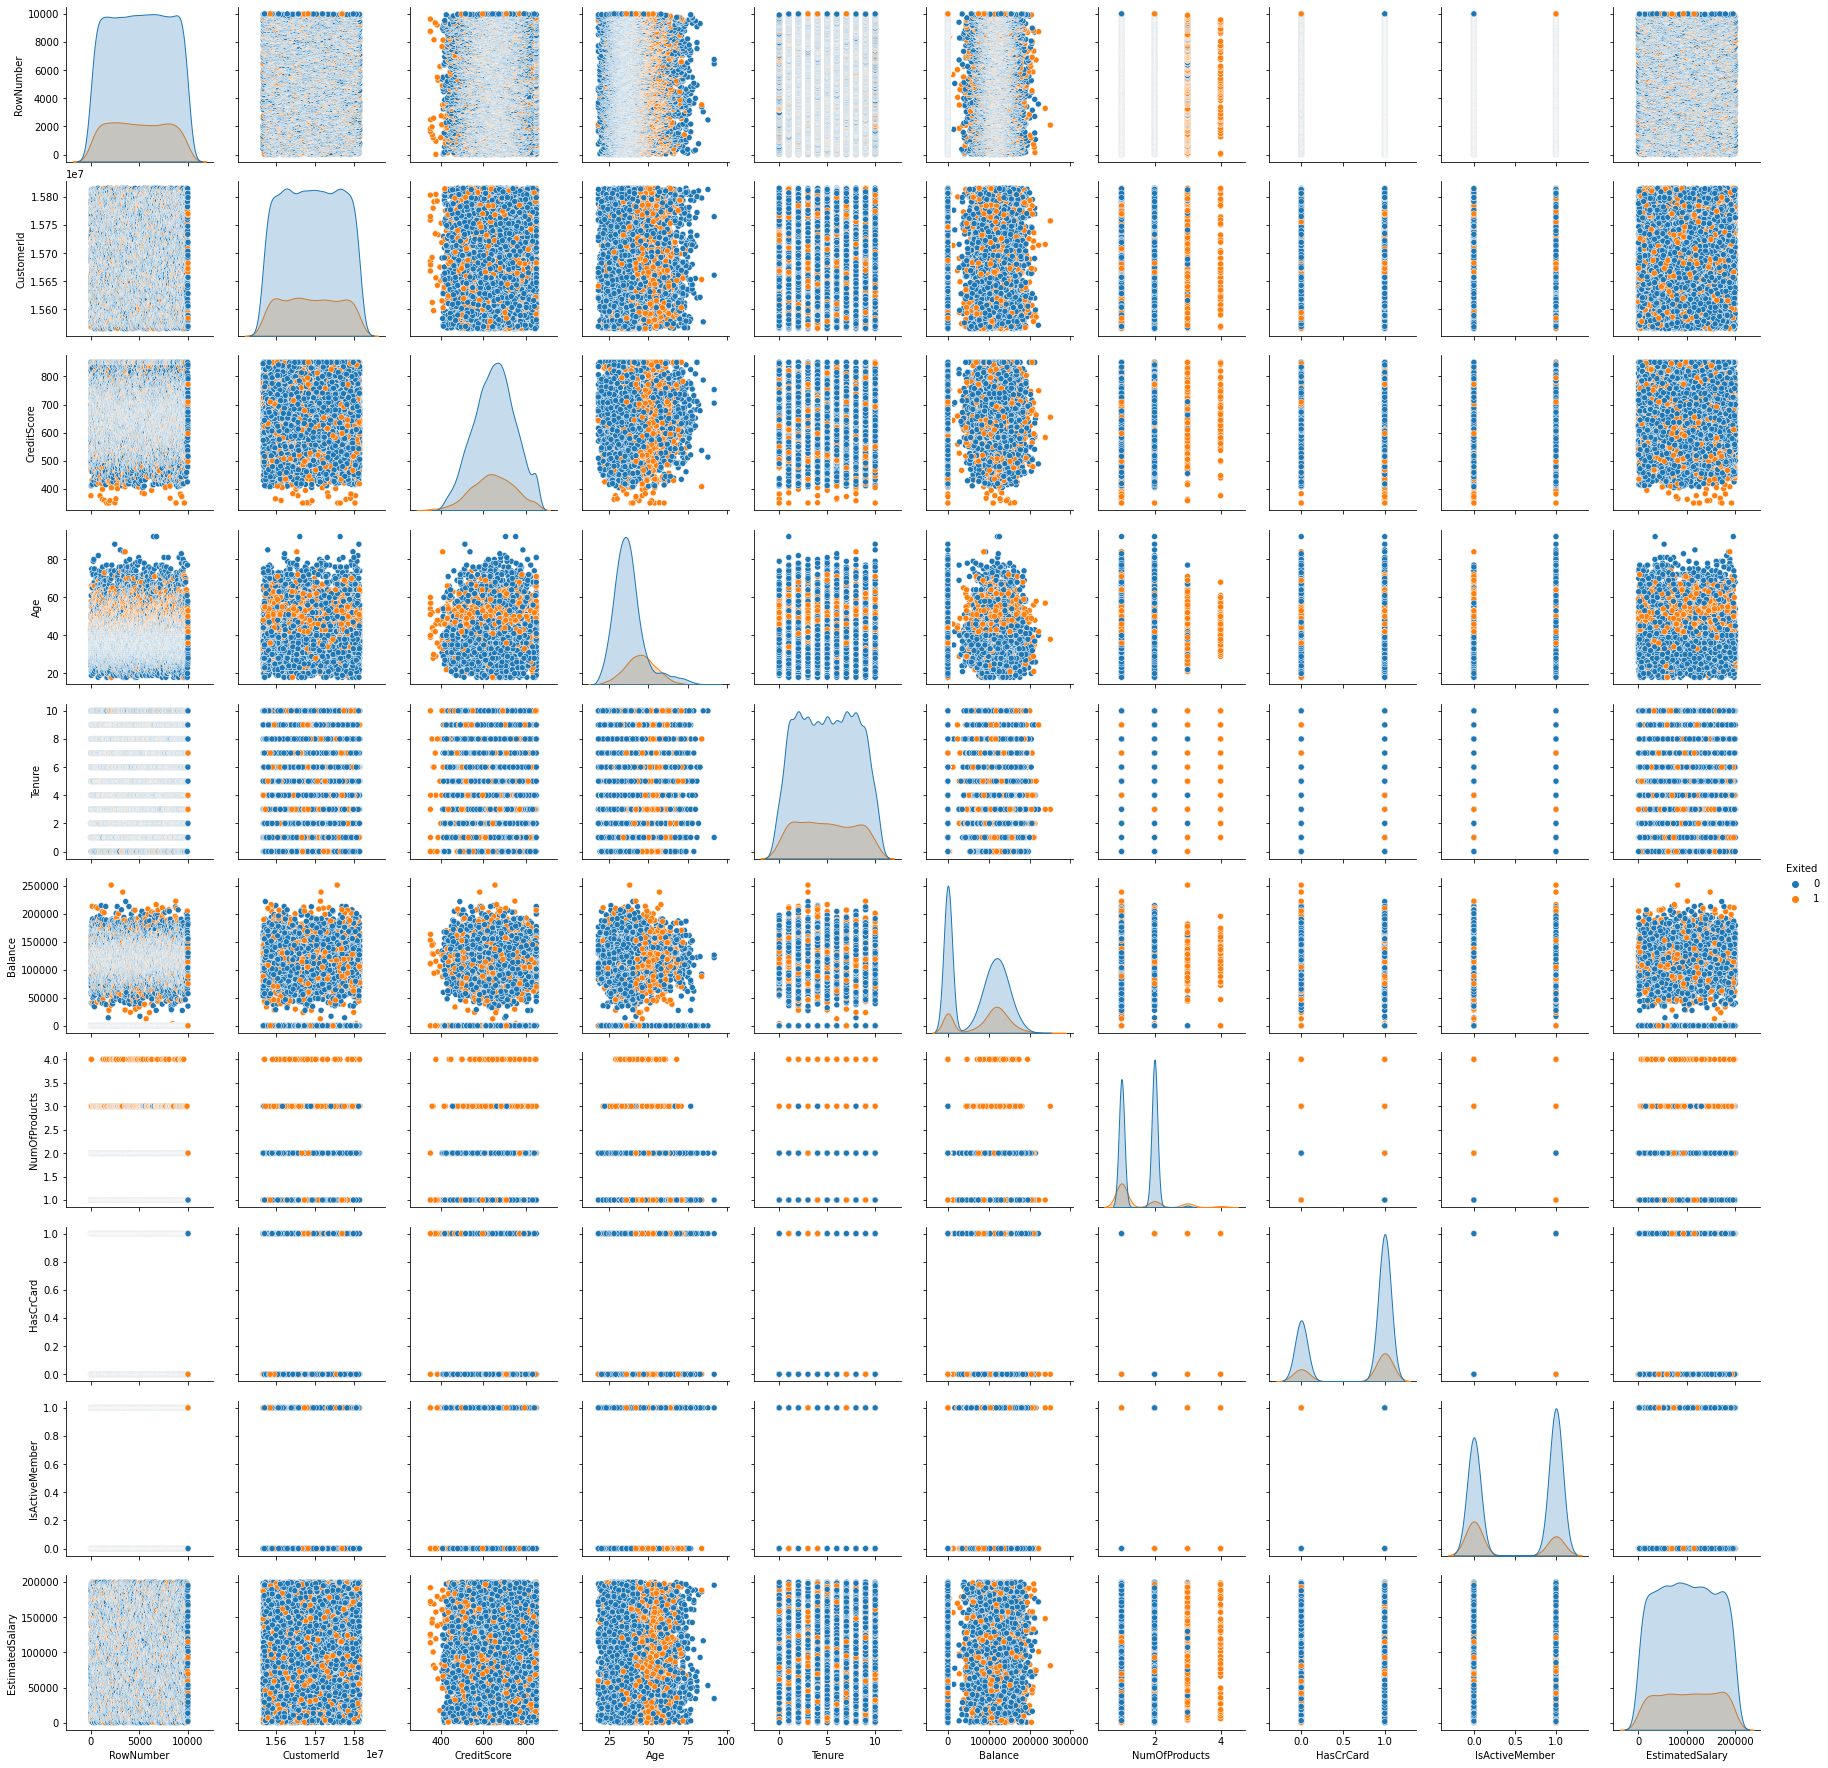

In [3]:
# Посмотрим, есть ли между какими-то данными датасета прямая корреляция
sns.pairplot(data, hue='Exited')

In [4]:
pd.pivot_table(data, index=['Gender', 'Geography'], values='Exited', aggfunc ='count')

Exited
Gender Geography        
Female France       2261
       Germany      1193
       Spain        1089
Male   France       2753
       Germany      1316
       Spain        1388

Посмотрела по сводной таблице. Распределение по полу незначительно больше в сторону мужчин, а вот в плане Географии можно сказать, что Франция заметно выделяется среди остальных стран. Значит, оставляем гендерные и географические данные в таблице.


In [5]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

Посмотрим, есть ли в данных пропуски

In [6]:
data.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

В признаке Tenure 909 пропущенных данных. Заполним пропуски слцчайными значениеми.

In [7]:
data['Tenure'] = data['Tenure'].fillna(random.choice(data['Tenure'].dropna()))

In [8]:
# Преобразуем категориальные признаки в численные методом OHE
data_ohe = pd.get_dummies(data, drop_first=True)

## Исследование задачи

In [9]:
target = data_ohe['Exited']
features = data_ohe.drop('Exited', axis=1)

In [10]:
# Разделим данные на тренировочную и валидационную выборки в соотношении 60:40
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features, target, test_size=0.4, random_state=12345)
# Разделим валидационную выборку на валидационную и тестовую выборки в соотношении 20:20
features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

Масштабируем данные

In [11]:
pd.options.mode.chained_assignment = None
numeric_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric_columns])
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_valid[numeric_columns] = scaler.transform(features_valid[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

In [12]:
# Модель решающего дерева
best_model = None
best_score = 0
max_depth = 0
for depth in range(1,200):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_score:
        best_model = model
        max_depth = depth 
        best_score = score 
print('Оптимальная глубина:', max_depth)
print('Лучшее значение f1-меры:', best_score)

Оптимальная глубина: 9
Лучшее значение f1-меры: 0.5766526019690578


In [13]:
%%time

# Модель случайного леса
best_model = None
best_score = 0
max_depth = 0
max_est = 0
for est in range(1, 100, 10):
    for depth in range(1, 50):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_score:
            best_model = model
            max_depth = depth 
            best_score = score
            max_est = est
print('Оптимальная глубина:', max_depth)
print('Количество деревьев:', max_est)
print('Лучшее значение f1-меры:', best_score)

Оптимальная глубина: 18
Количество деревьев: 51
Лучшее значение f1-меры: 0.5946745562130178
CPU times: user 2min 28s, sys: 718 ms, total: 2min 29s
Wall time: 2min 32s


In [14]:
# Модель логистической регрессии
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
score = f1_score(target_valid, predicted_valid)
print('Значение f1-меры:', score)

Значение f1-меры: 0.33389544688026984


Для каждой модели также построим ROC-кривую и посчитаем метрику AUC-ROC.

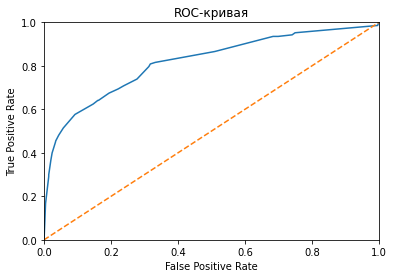

0.8164631712023421


In [15]:
# Модель решающего дерева
model = DecisionTreeClassifier(random_state=12345, max_depth=6)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

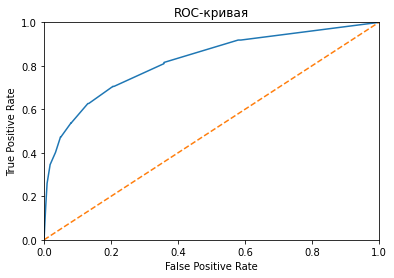

0.8217809205233517


In [16]:
# Модель случайного леса
model = RandomForestClassifier(random_state=12345, max_depth=20, n_estimators=11)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

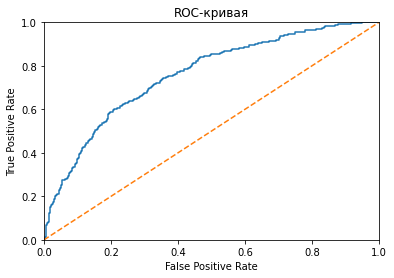

0.7587678972168959


In [17]:
# Модель логистической регрессии
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

Из 3 моделей лучший результат f1-меры показала модель случайного леса, почти такой же результат у модели решающего дерева. Самый худший результат показала модель логистической регрессии с почти нулевым значением. Значение AUC-ROC дает такое же распределение моделей. В целом можно сказать о несбалансированности классов во всех моделях.

## Борьба с дисбалансом

In [18]:
# Посмотрим на матрицу ошибок, чтобы понять, есть ли дисбаланс классов
confusion_matrix(target_valid, predicted_valid)

array([[1506,   76],
       [ 319,   99]])

Качество ответов модели- TN ответы почти в 20 раз превышают TP ответы. 

In [19]:
target_valid.value_counts()

0    1582
1     418
Name: Exited, dtype: int64

Дисбаланс классов есть - отрицательных ответов в 3 раза больше.

Попробуем добиться лучшего значения f1-меры с помощью уменьшения выборки

In [20]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
         [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
         [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
         features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3)

In [21]:
# Модель решающего дерева
best_model = None
best_score = 0
max_depth = 0
for depth in range(1,200):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_score:
        best_model = model
        max_depth = depth 
        best_score = score 
print('Оптимальная глубина:', max_depth)
print('Лучшее значение f1-меры:', best_score)

Оптимальная глубина: 5
Лучшее значение f1-меры: 0.579212916246216


In [22]:
%%time

# Модель случайного леса
best_model = None
best_score = 0
max_depth = 0
max_est = 0
for est in range(1, 100, 10):
    for depth in range(1,50):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_score:
            best_model = model
            max_depth = depth 
            best_score = score
            max_est = est
print('Оптимальная глубина:', max_depth)
print('Количество деревьев:', max_est)
print('Лучшее значение f1-меры:', best_score)

Оптимальная глубина: 5
Количество деревьев: 71
Лучшее значение f1-меры: 0.6273684210526317
CPU times: user 1min 24s, sys: 348 ms, total: 1min 25s
Wall time: 1min 25s


In [23]:
# Модель логистической регрессии
model = LogisticRegression(random_state=12345)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
score = f1_score(target_valid, predicted_valid)
print('Значение f1-меры:', score)

Значение f1-меры: 0.49905482041587906


Модели решающего дерева и случайного леса показали незначительный прирост f1-меры, а вот значение f1-меры для модели логистической регрессии увеличлось значительно, но всё равно остается худшим из 3 значений. 

Для каждой модели также построим ROC-кривую и посчитаем метрику AUC-ROC.

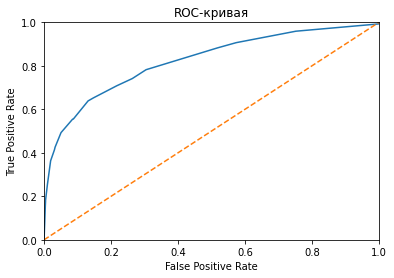

0.8221680508592478


In [24]:
# Модель решающего дерева
model = DecisionTreeClassifier(random_state=12345, max_depth=5)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

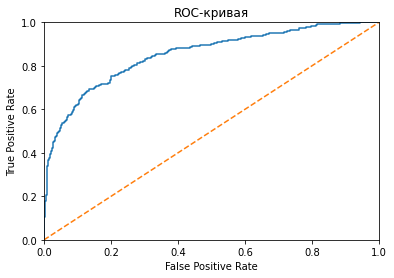

0.8518727429998972


In [25]:
# Модель случайного леса
model = RandomForestClassifier(random_state=12345, max_depth=6, n_estimators=61)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

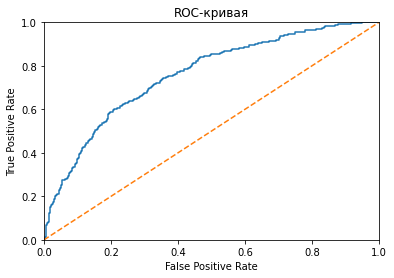

0.7587678972168959


In [26]:
# Модель логистической регрессии
model = LogisticRegression(random_state=12345)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

Лучшие показатели ROC-кривой и метрики AUC-ROC у модели решающего дерева, чуть хуже показатели у модели случайного леса. Модель логистической регрессии сильно уступает первым двум по качеству. 

Посмотрим еще на модели, используя метод взвешивания классов

In [27]:
# Модель решающего дерева
best_model = None
best_score = 0
max_depth = 0
for depth in range(1,200):
    model = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_score:
        best_model = model
        max_depth = depth 
        best_score = score 
print('Оптимальная глубина:', max_depth)
print('Лучшее значение f1-меры:', best_score)

Оптимальная глубина: 5
Лучшее значение f1-меры: 0.5963791267305644


In [28]:
%%time

# Модель случайного леса
best_model = None
best_score = 0
max_depth = 0
max_est = 0
for est in range(1, 100, 10):
    for depth in range(1,150):
        model = RandomForestClassifier(random_state=12345, class_weight='balanced', 
                                       max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_score:
            best_model = model
            max_depth = depth 
            best_score = score
            max_est = est
print('Оптимальная глубина:', max_depth)
print('Количество деревьев:', max_est)
print('Лучшее значение f1-меры:', best_score)

Оптимальная глубина: 9
Количество деревьев: 51
Лучшее значение f1-меры: 0.6350282485875706
CPU times: user 8min 8s, sys: 2.14 s, total: 8min 10s
Wall time: 8min 11s


In [29]:
# Модель логистической регрессии
model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
score = f1_score(target_valid, predicted_valid)
print('Значение f1-меры:', score)

Значение f1-меры: 0.4888888888888888


Для каждой модели также построим ROC-кривую и посчитаем метрику AUC-ROC.

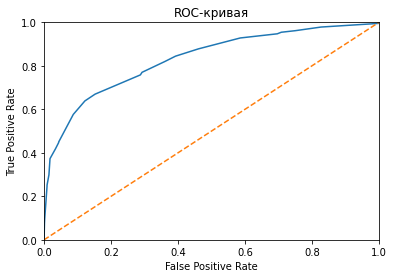

0.8310244134068074


In [30]:
# Модель решающего дерева
model = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=5)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

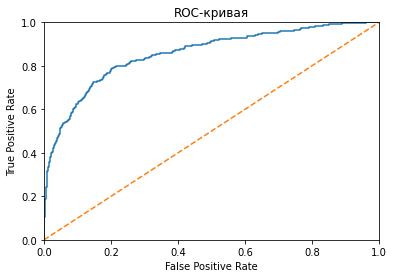

0.8559119036529377


In [31]:
# Модель случайного леса
model = RandomForestClassifier(random_state=12345, class_weight='balanced', max_depth=8,
                               n_estimators=81)
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

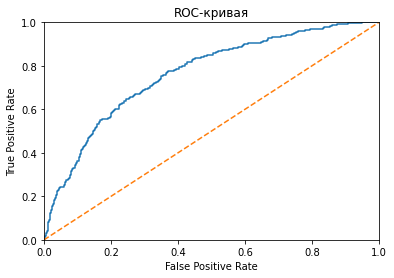

0.7635525862121111


In [32]:
# Модель логистической регрессии
model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print(auc_roc)

Провели борьбу с дисбалансом 2 методами: 1. Downsampling - показал плохие результаты, значение f1-меры и AUC-ROC снизились для моделей решющего дерева и случайного леса. При это эти значения поднялись для модели логистической регрессии, но не настолько, чтобы считать эти результаты значимыми. 2. Метод взвешивания классов - показал хорошие результаты. Лучшие результаты дала модель случайного леса с гиперпараметрами: Оптимальная глубина: 8, Количество деревьев: 81. f1-мера = 0.63, а AUC-ROC = 0.85

Проведем тестирование модели, показавшей лучший результат - модели случайного леса методом взвешивания классов. 

In [33]:
# Модель случайного леса
best_model = None
best_score = 0
max_depth = 0
max_est = 0
for est in range(1, 100, 10):
    for depth in range(1,50):
        model = RandomForestClassifier(random_state=12345, class_weight='balanced', 
                                       max_depth=depth, n_estimators=est)
        model.fit(features_train, target_train)
        predicted_test = model.predict(features_test)
        score = f1_score(target_test, predicted_test)
        if score > best_score:
            best_model = model
            max_depth = depth 
            best_score = score
            max_est = est
print('Оптимальная глубина:', max_depth)
print('Количество деревьев:', max_est)
print('Лучшее значение f1-меры:', best_score)

Оптимальная глубина: 7
Количество деревьев: 81
Лучшее значение f1-меры: 0.6163391933815926


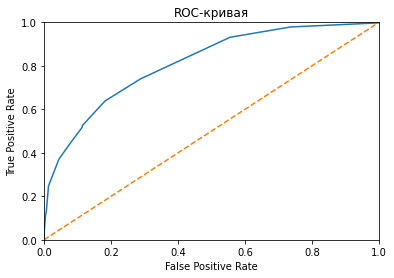

0.8119015816907046


In [34]:
# Построим ROC-кривую и посчитаем метрику AUC-ROC
model = DecisionTreeClassifier(random_state=12345, max_depth=4)
model.fit(features_train, target_train)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)

В проекте я:
1. Изучила и подготовила к дальнейшим исследованиям данные - неинформативные признаки были удалены, другие масштабированы. 
2. Исследовала баланс классов и обучила модели без учета дисбаланса. 
3. Затем решила попробовать 2 метода борьбы с дисбалансом: downsampling и метод взвешивания классов. Лучшей моделью при этом оказалась модель случайного леса, метод - метод взвешивания классов. Она показала значение f1-меры, равное 0,63, значение AUC-ROC = 0,85. На тестовой выборке эта модель также не подвела, показав значение f1-меры = 0,62 и AUC-ROC = 0,81.